<a href="https://colab.research.google.com/github/EugeneFrancisco/Ito-Visual/blob/main/ItoVisual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background: Quadratic Variation and the Itô Correction

The quadratic variation of a Brownian Motion is the underlying feature which forces us to incorporate a *drift correction term* in the explicit solutions to functions whose rates of change are proportional to the changes in the Brownian Motion.

In this project, I wanted to visualize the quadratic variation of Brownian Motion and see how this affects the solutions to SDEs which use Brownian Motion. On the way, we'll see how the solutions to these SDEs differs from standard calculus and how the Itô correction works.

In [ ]:
import math
import random
from matplotlib import pyplot as plt

## Creating our Brownian Motion

In [ ]:
def brownian(T, n):
    '''
    Returns a list representing the path taken by the brownian motion where T is the total time of the path
    n is the discretized number of time segments. The returned list is length n + 1, (includes B(0)).

    For example, Brownian(10, 5) returns [B(0), B(2), B(4), B(6), B(8), B(10)]
    '''
    path = [0]
    variance = T/n
    for t in range(n):
        dBt = random.gauss(mu = 0, sigma = math.sqrt(variance))
        nextPath = path[t] + dBt
        path.append(nextPath)
    return path

## Modeling Quadratic Variation

A refresher on the **Theorem for Quadratic Variation of Brownian Motion**. Let $B(t)$ be a Brownian Motion. Then

$$\begin{gather}\lim_{n\to \infty} \sum_{i = 1}^n \left(B\left( \frac{i}{n}T\right) - B\left( \frac{i-1}{n}T\right)\right)^2 = T,\\
dB(t)^2 = dt\tag{2}
\end{gather}$$

In words, the theorem states that if we cut up the interval from $0$ to $T$ into $n$ little chunks and then sum all the squared differences (the quadratic variations) between adjacent chunks, the sum approaches the size of the interval $T$. **The proof** for this follows from the fact that $dB(t) \sim \mathcal{N}(0, dt)$ so that $\mathbb{E}(dB(t)^2) = dt$. With a bit of handwaving, the sum of all these tiny $dB(t)^2$ then gives us the sum of all the $dt$, which is just $T$.

## Try it yourself!

Below, we can see that the "running sum" (the blue line) of all the quadratic variations indeed looks like just a straight line starting from $0$. The green line is the underlying Brownian Motion generated. The printed sum at the end gets closer and closer to $T$ the higher we push $n$. **Try it yourself. Change n and T in the second code block below and see!**

In [ ]:
def modelQuadraticVariation(path):
    '''
    Given a stochastic path, returns the quadratic variation of the path.
    '''
    sum = 0
    runningSum = [0]
    for t in range(len(path)-1):
        Bt = path[t]
        Btplusone = path[t+1]
        squaredDiff = (Btplusone-Bt)**2
        sum += squaredDiff
        runningSum.append(sum)

    return runningSum

Quadratic Variation from 0 to T:  10.133151556224488


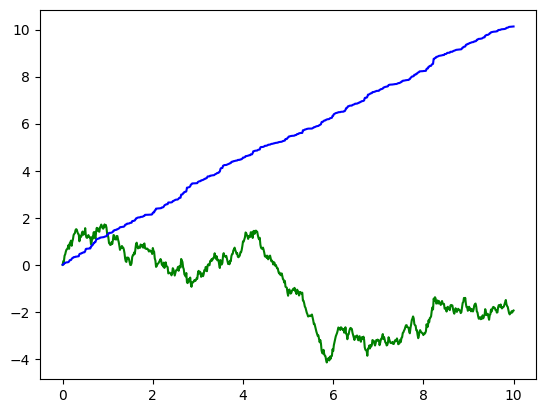

In [ ]:
# Change n and T and see how it changes the approximation
n = 700
T = 10

path = brownian(T = T, n = n)
runningSum = modelQuadraticVariation(path)
print("Quadratic Variation from 0 to T: ", runningSum[n])

timeAxis = [i * T/n for i in range(n+1)]
plt.plot(timeAxis, path, color = "green")
plt.plot(timeAxis, runningSum, color = "blue")
plt.show()

# The Itô Correction

It turns out that specifically because of this quadratic variation property that $dB(t)^2 = dt$, functions which take in Brownian Motion as input behave with an unexpected "drift." Take the differential equation
$$df(x) = 2xdx.$$
From standard calculus, we know that an explicit solution to the function is just
$$f(x) = x^2.$$
Now take the stochastic differential equation
$$dg(B(t)) = 2B(t)dB(t)\tag{3}.$$
We might make a similar guess and say that an explicit solution is
$$\hat{g}(B(t)) = B(t)^2\tag{4},$$
**but this is actually wrong!**


**To demonstrate this** we'll begin by modeling $(3)$. We'll first generate a Brownian Motion with `brownian()`  and then write a new function `quadraticPathWise()` to take in that Brownian Motion and find how $g$ evolves by *only* using $(3)$ to generate function values (with an initial value of $g(0) = 0$). Then, using that same Brownian Motion, we'll try out our explicit solution in $(4)$ and see how off we are.

In [ ]:
def quadraticPointWise(numDivisions, path):
    '''
    Given path, a Brownian motion, quadraticPointWise divides the path into N evenly spaced segments and then
    uses those segments to estimate the value of f satisfying the differential equation dg(B(t)) = 2*B(t)*dB(t).

    The dB(t) are calculated from the N evenly spaced segments. If n is the length of the path, then
    the  where t takes on the values
    t = T/N, 2T/N, ... NT/N. For example, dB(0) is estimated by looking at the
    difference B(T/N) - B(0).

    *Note, N must divide the length of the path (excluding B(0)). So if the passed in path is length 11 with
    B(0), B(1), ..., B(10), then 5|10, so N = 5 works, but N = 3 does not. For N = 5 and a path length of 11,
    dB(t) is B(2) - B(0), B(4) - B(2), B(6) - B(4), B(8) - B(6), and B(10) - B(8).
    '''

    n = len(path)

    if ((n-1) % numDivisions != 0):
        raise(ValueError)

    functionValues = [0]

    for i in range(numDivisions):
        dBt = path[int((i + 1) * (n - 1) / numDivisions)] - path[int(i * (n - 1) / numDivisions)]
        dG = 2 * path[int(i * (n - 1) / numDivisions)] * dBt
        functionValues.append(functionValues[i] + dG)

    return functionValues


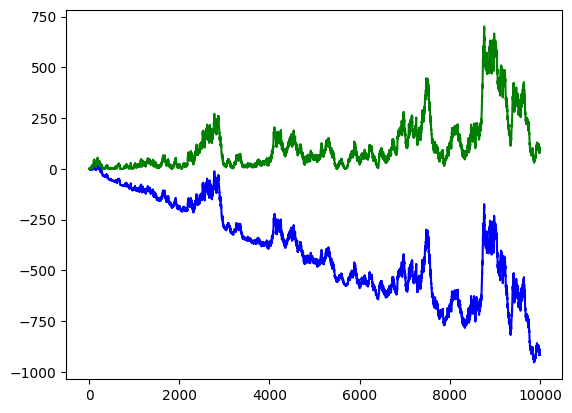

In [ ]:
# Feel free to change T and n!
T = 1000
n = 10000
brownianPath = brownian(T = T, n = n)
explicitBadGuess = [b**2 for b in brownianPath]
implicitFunctionPath = quadraticPointWise(numDivisions = n, path = brownianPath)
plt.plot(implicitFunctionPath, color = "blue")
plt.plot(explicitBadGuess, color = "green")

**As we can see** above, there is a significant difference between the blue line (which comes from our SDE) and the green line (our wrong guess for an explicit solution). Increasing the number of subdivisions doesn't seem to help either (try changing `n` in the code above).

## The Itô Correction

To fix this, we use the Itô correction. A brief refresher: expanding $df(B(t))$ using a standard taylor series, we see that
$$df(B(t)) = f'(B(t))dB(t) + \frac{f''(B(t))}{2}\underbrace{dB(t)^2}_{dt} + \cdots \tag{5}$$
When we guessed our previous solution, we forgot to account for this second derivative term in the taylor series. Let's apply $(5)$ to our guess in $(4)$:
$$\begin{align*}
d\hat{g}(B(t)) &= \hat{g}'(B(t))dB(t) + \frac{\hat{g}''(B(t))}{2}dB(t)^2 + \cdots\\
&= 2B(t)dB(t) + \frac{2}{2}\underbrace{dB(t)^2}_{dt}\\
&= 2B(t)dB(t) + dt\tag{6}
\end{align*}$$
In $(6)$, we see the appearence of extra $dt$ term which did not appear in our original SDE $(3)$! In other words, our wrong guess in $(4)$ was *drifting* up by some little $dt$. To correct for this, we can make a clever guess to "cancel out" the drift term which appears in $(6)$. Specifically, we'll let

$$g(t, B(t)) = B(t)^2 - t\tag{7}$$

**Let's use this to make a correct guess** for the explicit solution and compare it to our path. Critically, because the assumption $dB(t)^2 = dt$ was as $n\to\infty$, we expect our explicit solution to be "more and more correct" as the number of subdivisions `numDivisions` goes higher below. *Note, numSubdivisions must divide `n` above for the divisions to work cleanly.

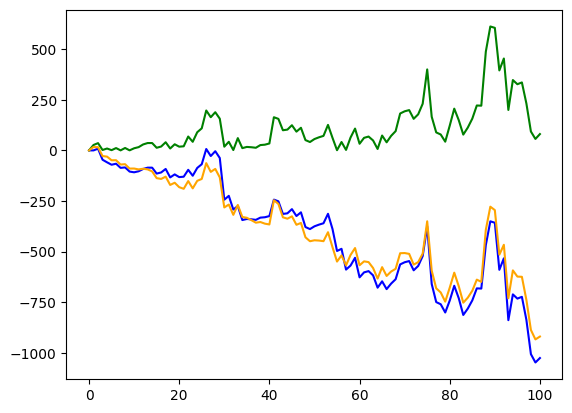

In [ ]:
numDivisions = int(n/100)

explicitGoodGuess = [b**2 -1 * i * T / n for i, b in enumerate(brownianPath)]
implicitFunctionPath = quadraticPointWise(numDivisions = numDivisions, path = brownianPath)

slicedBadGuess = [explicitBadGuess[int(i * n / numDivisions)] for i in range(numDivisions+1)]
slicedGoodGuess = [explicitGoodGuess[int(i * n / numDivisions)] for i in range(numDivisions+1)]

plt.plot(implicitFunctionPath, color = "blue")
plt.plot(slicedBadGuess, color = "green")
plt.plot(slicedGoodGuess, color = "orange")


As before, the blue line is our implicit solution modeled from the SDE in $(3)$ and the green line is the wrong guess at an explicit solution in $(4)$. Meanwhile, the orange line is the new correct guess from $(7)$. The orange and the blue are almost identical! But they will start to differ as we make (try it!) `numDivisions` smaller in the code block above since the assumption that $dB(t)^2 = dt$ breaks down.

Indeed, using the multivariable Taylor Series with $(7)$, we see that
$$\begin{align*}
dg(t, B(t)) &= \partial_{B(t)} g(t, B(t))dB(t) + \partial_{t}g(t, B(t))dt + \frac{\partial_{B(t)}g(B(t))}{2}\underbrace{dB(t)^2}_{dt} + \cdots\tag{8}\\
&= 2B(t)dB(t) - dt + dt\\
&= 2B(t)dB(t),
\end{align*}$$
which is exactly what we want.

# Applied to Share Prices

To model share prices, we have to adjust for this same drift. If $S$ is the price of a share, we assume that the percent returns of the share price $dS/S$ follows a Brownian Motion along with a little bit of drift proportional to time, so $S$ is a function of both $B(t)$ and $t$. We'll use the notation $S_{t, B(t)}$ to remove clutter:
$$\frac{dS_{t, B(t)}}{S_{t, B(t)}} = \mu dt + \sigma dB(t),\tag{9}$$
where $\mu$ is the drift rate of the stock over time and $\sigma$ is the standard deviation of the percent returns. These should be interpreted as a drift rate and standard deviation *per unit time*.

Rearranging $(9)$, we have
$$dS_{t, B(t)} = S_{t, B(t)}\left(\mu dt + \sigma dB(t)\right),\tag{10}$$

which is the Stochastic Differential Equation we will ultimately use. A clever (but wrong) guess we might make is that

$$\hat{S}_{t, B(t)} = \exp(\mu t + \sigma B(t))\tag{11}$$

Indeed, applying $(8)$ to $(11)$, we find that
$$d\hat{S}_{t, B(t)} = \hat{S}_{t, B(t)}(\mu dt + \sigma dB(t)) + \underbrace{\frac{\hat{S}_{t, B(t)}\sigma^2}{2}dB(t)^2}_{\text{drift term}}$$

where that additional drift term is visible at the end. To correct for this, we'll make a clever guess to "cancel out" that drift:

$$\begin{align*}
S_{t, B(t)} &= \exp\left(\mu t - \frac{1}{2}\sigma^2 t + \sigma B(t)\right)\\
&= \exp\left((\mu - \frac{1}{2}\sigma^2)t + \sigma B(t)\right)\tag{12}
\end{align*}$$

which is the final explicit formula we'll use for our correct solution.

## Visualizing the Share Prices

Like before, we make a function `sharePointWise` which takes in a Brownian Motion and uses $(10)$ to generate the share prices (with an initial value of $S(0, B(0)) = 1)$. Then, we'll compare the bad guess without the correction term in $(11)$ with the correct answer in $(12)$. We'll also note how the drift gets worse as we take the number of subdivisions `numSubdivisions` to be smaller.

**Note, I've used $\mu = 0.01$ and $\sigma = 0.003$ arbitrarily since with these numbers, the simulation looks roughly similar to an actual share price once MatPlotLib scales the price axis.*

In [ ]:
def sharePointWise(T, N, path, mu, sigma):
    n = len(path)
    dt = T / N

    if ((n-1) % N != 0):
        raise(ValueError)

    sharePath = [1]

    for i in range(N):
        dBt = path[int((i + 1) * (n - 1) / N)] - path[int(i * (n - 1) / N)]
        dS = sharePath[i] * mu * dt + sharePath[i] * sigma * dBt
        sharePath.append(sharePath[i] + dS)

    return sharePath

In [ ]:
'''
Setting up the Brownian Motion and the explicit guesses
'''
T = 500
numDays = 500
mu = 0.01
sigma = 0.05
brownianPath = brownian(T = T, n = numDays)
timeAxis = [i * T/numDays for i in range(numDays+1)]
sharePathExplicitBadGuess = [math.exp(mu * i * T/numDays + sigma * b) for i, b in enumerate(brownianPath)]
sharePathExplicitGoodGuess = [math.exp( (mu - 0.5 * sigma **2)*i*T/numDays + sigma * b) for i, b in enumerate(brownianPath)]

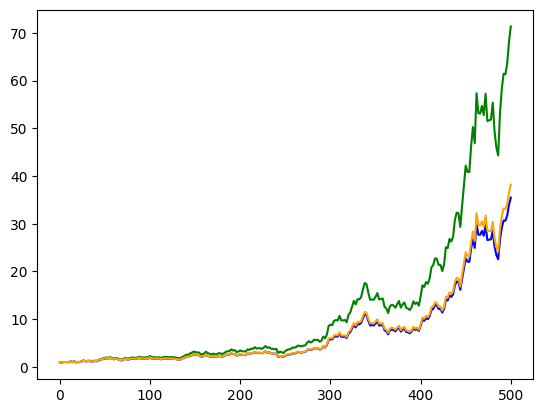

In [ ]:
numSubdivisions = int(numDays/2)

sharePathImplicit = sharePointWise(T = T, N = numSubdivisions, path = brownianPath, mu = mu, sigma = sigma)
functionTimeAxis = [i * T / numSubdivisions for i in range(numSubdivisions+1)] # functionTimeAxis are the values T/N, 2T/N, 3T/N, ... NT/N = T

slicedGoodGuess = [sharePathExplicitGoodGuess[int(i * numDays / numSubdivisions)] for i in range(numSubdivisions+1)]
slicedBadGuess = [sharePathExplicitBadGuess[int(i * numDays / numSubdivisions)] for i in range(numSubdivisions+1)]

plt.plot(functionTimeAxis, sharePathImplicit, color = "blue")
plt.plot(functionTimeAxis, slicedBadGuess, color = "green")
#plt.plot(timeAxis, sharePathExplicitGoodGuess, color = "orange")
plt.plot(functionTimeAxis, slicedGoodGuess, color = "orange")


As before, the blue line is modeled using our SDE in $(10)$; our bad guess from $(11)$ is the green line and the drift is clearly visible. Finally, the good guess from $(12)$ is the orange, which gets closer and closer to $(10)$ as `numSubdivisions` grows.